In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)

In [2]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import product
from datetime import datetime
from scipy import stats
from sklearn.metrics import mean_squared_error

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.stattools import adfuller

# import statsmodels.formula.api as smf
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./data/btc_daily_all.csv', parse_dates=['Date'], \
                 index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [4]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.shape

(2975, 1)

In [5]:
df = df.loc[df.index > '2011-12-31']
df.columns = ['Price']
df.head()

,Price
Date,
2012-01-01,5.27
2012-01-02,5.22
2012-01-03,4.88
2012-01-04,5.57
2012-01-05,6.95


In [6]:
print(df.describe())
print('===================')
print(df.dtypes)

              Price
count   2442.000000
mean    1701.009751
std     3143.328980
min        4.220000
25%      135.000000
50%      423.894989
75%      957.307511
max    19345.490234
Price    float64
dtype: object


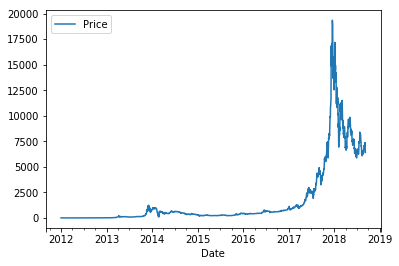

In [8]:
df.plot()

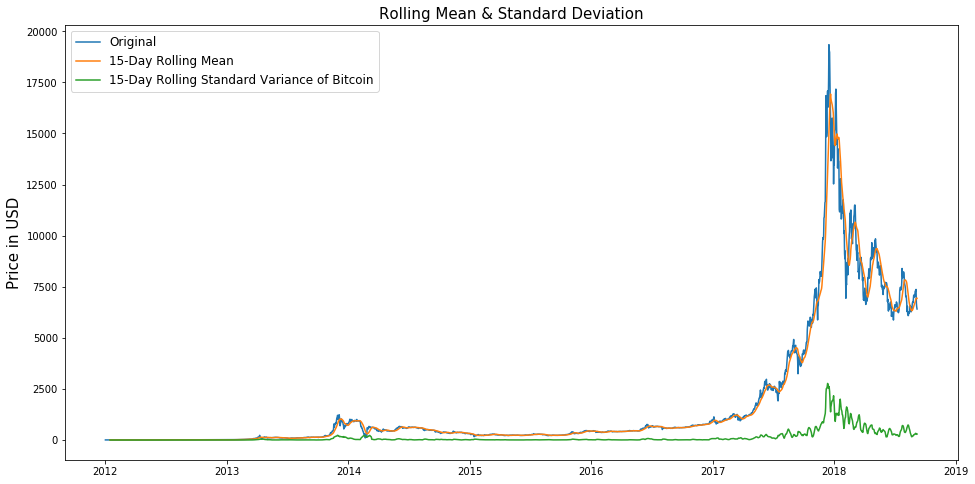

In [77]:
plt.figure(figsize=(16,8))
rolmean = df['Price'].rolling(window=15).mean()
rolvar = df['Price'].rolling(window=15).std()
plt.plot(df['Price'], label='Original')
plt.plot(rolmean, label='15-Day Rolling Mean')
plt.plot(rolvar, label='15-Day Rolling Standard Variance of Bitcoin')
plt.legend(loc='best', fontsize=12)
plt.ylabel('Price in USD', fontsize=15)
plt.title('Rolling Mean & Standard Deviation', fontsize=15)
plt.show(block=False)

In [10]:
df_month = df.resample('M').mean()
df_qrt   = df.resample('Q-DEC').mean()
df_year  = df.resample('A-DEC').mean()

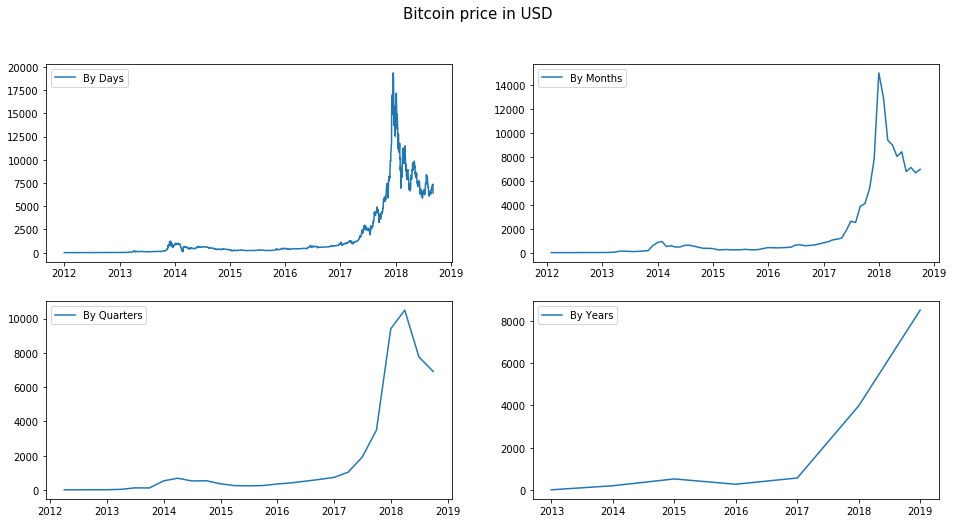

In [11]:
fig = plt.figure(figsize=[16, 8])
plt.suptitle('Bitcoin price in USD', fontsize=15)
plt.subplot(221)
plt.plot(df.Price, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_qrt.Price, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='By Years')
plt.legend()
# plt.tight_layout()
plt.show()

In [12]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [13]:
test_stationarity(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.643327
p-value                           0.460523
#lags Used                       27.000000
Number of Observations Used    2414.000000
Critical Value (1%)              -3.433062
Critical Value (5%)              -2.862738
Critical Value (10%)             -2.567408
dtype: float64


Decomposition of time series: Daily


<Figure size 2160x864 with 0 Axes>

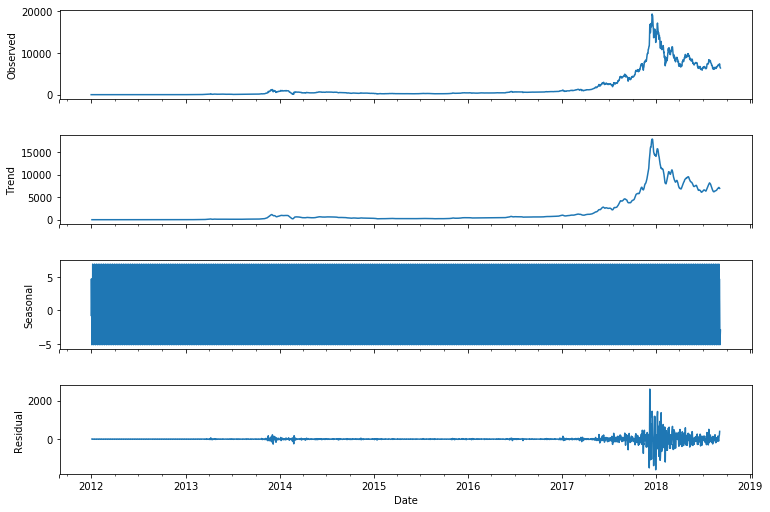

In [25]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(df['Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Daily')
plt.show()

In [26]:
log_dfd = df.copy()
log_dfd.columns = ['Log.Price']
log_dfd['Log.Price'] = np.log(log_dfd['Log.Price'])
log_dfd.head()

,Log.Price
Date,
2012-01-01,1.662030
2012-01-02,1.652497
2012-01-03,1.585145
2012-01-04,1.717395
2012-01-05,1.938742


In [27]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(log_dfd['Log.Price'])[1])
test_stationarity(log_dfd['Log.Price'])

Dickey–Fuller test: p=0.620962
Results of Dickey-Fuller Test:
Test Statistic                   -1.317861
p-value                           0.620962
#lags Used                        9.000000
Number of Observations Used    2432.000000
Critical Value (1%)              -3.433042
Critical Value (5%)              -2.862729
Critical Value (10%)             -2.567403
dtype: float64


Decomposition of time series: Daily Log


<Figure size 2160x864 with 0 Axes>

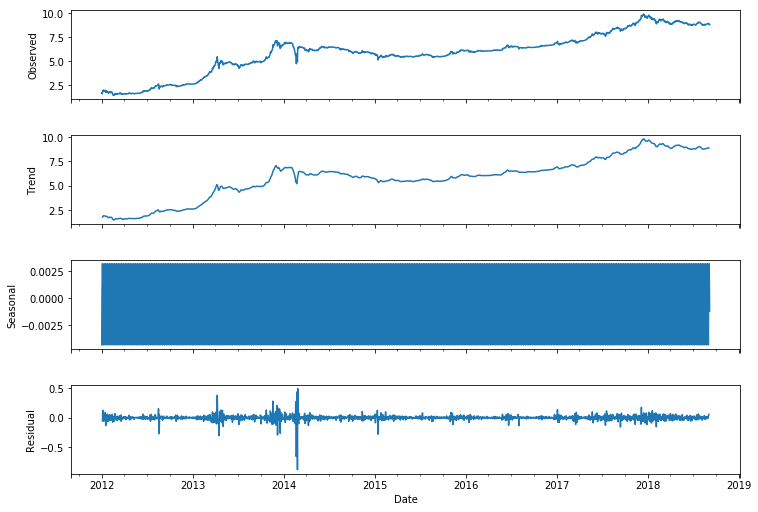

In [28]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(log_dfd['Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Daily Log')
plt.show()

In [29]:
ret_log_dfd = log_dfd.copy()
ret_log_dfd.columns = ['Ret.Log.Price']
ret_log_dfd['Ret.Log.Price'] = ret_log_dfd['Ret.Log.Price'].diff()
ret_log_dfd = ret_log_dfd.iloc[1:]
ret_log_dfd.head(2)

,Ret.Log.Price
Date,
2012-01-02,-0.009533
2012-01-03,-0.067352


In [30]:
test_stationarity(ret_log_dfd['Ret.Log.Price'])

Results of Dickey-Fuller Test:
Test Statistic                -1.730948e+01
p-value                        5.565718e-30
#lags Used                     8.000000e+00
Number of Observations Used    2.432000e+03
Critical Value (1%)           -3.433042e+00
Critical Value (5%)           -2.862729e+00
Critical Value (10%)          -2.567403e+00
dtype: float64


Decomposition of time series: Log Return


<Figure size 2160x864 with 0 Axes>

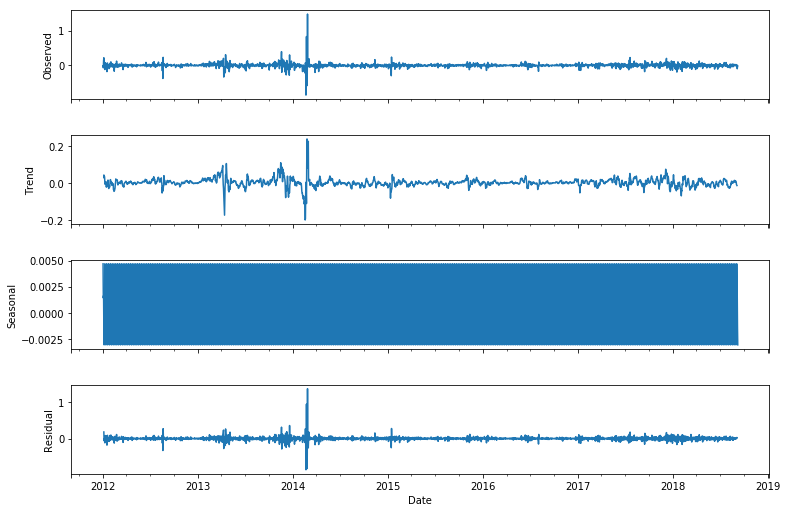

In [31]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(ret_log_dfd['Ret.Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Log Return')
plt.show()

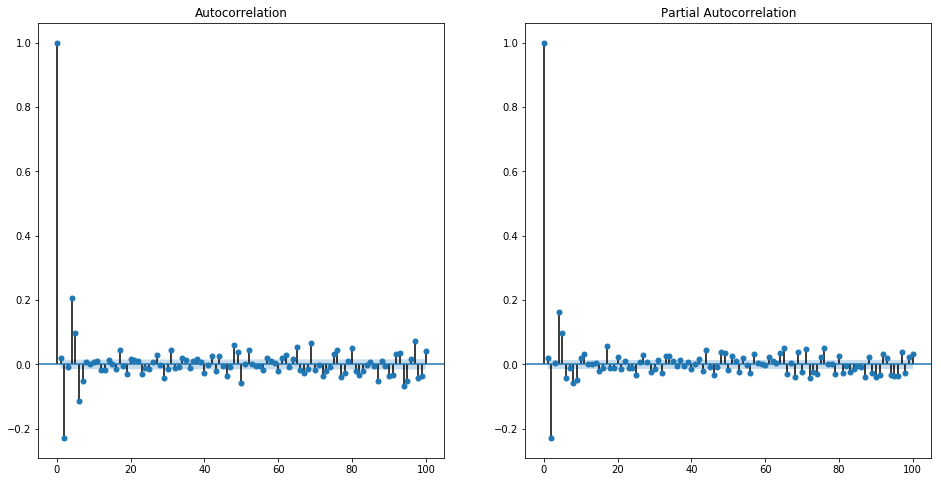

In [79]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
smt.graphics.plot_acf(ret_log_dfd['Ret.Log.Price'], lags=100, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ret_log_dfd['Ret.Log.Price'], lags=100, ax=axes[1], alpha=0.5)
# plt.tight_layout()
plt.show()

In [42]:
Qs = range(0,1)
qs = range(0,8)
Ps = range(0,1)
ps = range(0,8)
Ds = range(0,1)
ds = range(0,3)
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
print(len(parameters_list))
parameters_list[:10]

192


[(0, 0, 0, 0, 0, 0),
 (0, 0, 1, 0, 0, 0),
 (0, 0, 2, 0, 0, 0),
 (0, 0, 3, 0, 0, 0),
 (0, 0, 4, 0, 0, 0),
 (0, 0, 5, 0, 0, 0),
 (0, 0, 6, 0, 0, 0),
 (0, 0, 7, 0, 0, 0),
 (0, 1, 0, 0, 0, 0),
 (0, 1, 1, 0, 0, 0)]

In [43]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(log_dfd['Log.Price'], order=(param[0], param[1], param[2]), \
                                        seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 1, 0, 0, 0)
wrong parameters: (0, 0, 3, 0, 0, 0)
wrong parameters: (0, 0, 4, 0, 0, 0)
wrong parameters: (0, 0, 5, 0, 0, 0)
wrong parameters: (0, 0, 6, 0, 0, 0)
wrong parameters: (0, 0, 7, 0, 0, 0)
wrong parameters: (0, 2, 2, 0, 0, 0)
wrong parameters: (0, 2, 6, 0, 0, 0)
wrong parameters: (0, 2, 7, 0, 0, 0)
wrong parameters: (1, 0, 0, 0, 0, 0)
wrong parameters: (1, 0, 1, 0, 0, 0)
wrong parameters: (1, 0, 2, 0, 0, 0)
wrong parameters: (1, 0, 3, 0, 0, 0)
wrong parameters: (1, 0, 4, 0, 0, 0)
wrong parameters: (1, 0, 5, 0, 0, 0)
wrong parameters: (1, 0, 6, 0, 0, 0)
wrong parameters: (1, 0, 7, 0, 0, 0)
wrong parameters: (1, 2, 1, 0, 0, 0)
wrong parameters: (1, 2, 2, 0, 0, 0)
wrong parameters: (1, 2, 6, 0, 0, 0)
wrong parameters: (1, 2, 7, 0, 0, 0)
wrong parameters: (2, 0, 0, 0, 0, 0)
wrong parameters: (2, 0, 1, 0, 0, 0)
wrong parameters: (2, 0, 2, 0, 0, 0)
wrong parameters: (2, 0, 3, 0, 0, 0)
wrong parameters: (2, 0, 4, 0, 0, 0)
wrong parameters: (2, 0, 5, 0, 0, 0)
w

In [44]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

            parameters          aic
61  (4, 1, 5, 0, 0, 0) -6826.704885
9   (0, 1, 7, 0, 0, 0) -6825.767426
33  (2, 1, 6, 0, 0, 0) -6825.242742
22  (1, 1, 7, 0, 0, 0) -6824.732558
76  (5, 1, 5, 0, 0, 0) -6824.554186
                           Statespace Model Results                           
Dep. Variable:              Log.Price   No. Observations:                 2442
Model:               SARIMAX(4, 1, 5)   Log Likelihood                3423.352
Date:                Mon, 17 Sep 2018   AIC                          -6826.705
Time:                        01:41:13   BIC                          -6768.703
Sample:                    01-01-2012   HQIC                         -6805.622
                         - 09-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

Dickey–Fuller test:: p=0.000000


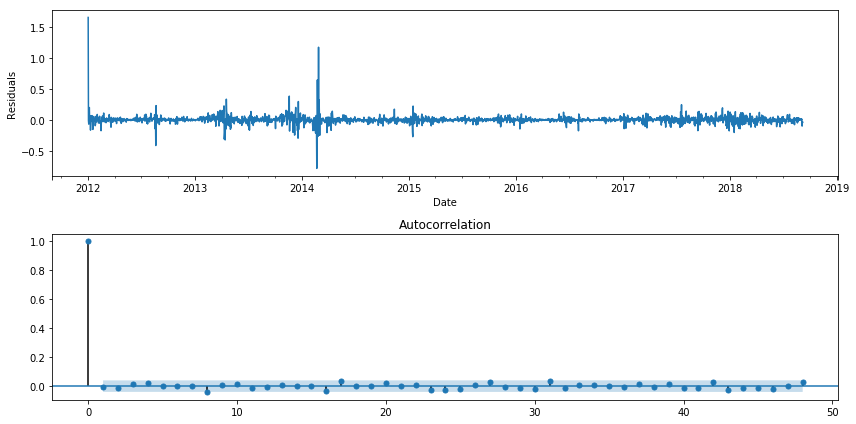

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(211)
best_model.resid[0:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid, lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
plt.tight_layout()
plt.show()

In [46]:
print(df.head(2))
print(df.tail(2))
df.shape

            Price
Date             
2012-01-01   5.27
2012-01-02   5.22
                  Price
Date                   
2018-09-06  6515.419922
2018-09-07  6411.779785


(2442, 1)

In [47]:
best_model.predict(start=2438, end=2446)

2018-09-04    8.890654
2018-09-05    8.909879
2018-09-06    8.810194
2018-09-07    8.800573
2018-09-08    8.769305
2018-09-09    8.753322
2018-09-10    8.735188
2018-09-11    8.736243
2018-09-12    8.742143
Freq: D, dtype: float64

In [52]:
pred_log = pd.DataFrame(best_model.predict(start=0, end=2480))
pred_log.index.name = 'Date'
pred_log.columns = ['Pred.Log.Price']
pred_log['Pred.Log.Price'] = pred_log['Pred.Log.Price'].shift(-1)
pred_log.head(3)

,Pred.Log.Price
Date,
2012-01-01,1.662030
2012-01-02,1.652264
2012-01-03,1.585300


In [50]:
log_dfd.head(2)

,Log.Price
Date,
2012-01-01,1.662030
2012-01-02,1.652497


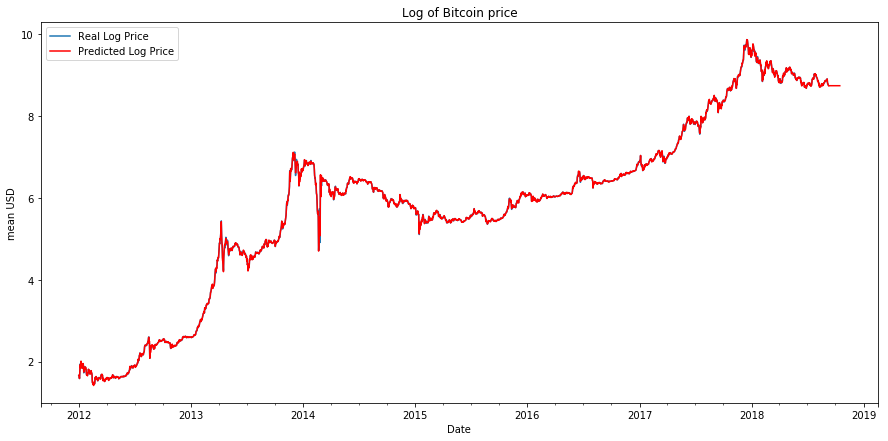

In [53]:
plt.figure(figsize=(15,7))
log_dfd['Log.Price'].plot(label='Real Log Price')
pred_log['Pred.Log.Price'].plot(color='r', label='Predicted Log Price') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [56]:
print(log_dfd.shape, pred_log[:-39].shape)

(2442, 1) (2442, 1)


In [57]:
mse = mean_squared_error(log_dfd['Log.Price'], pred_log['Pred.Log.Price'].iloc[:-39])
mse

0.00038684925186974054

In [58]:
print(df.index[:5])
print(best_model.fittedvalues.index[:5])

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
# def invboxcox(y,lmbda):
#     if lmbda == 0:
#         return(np.exp(y))
#     else:
#         return(np.exp(np.log(lmbda*y+1)/lmbda))

In [59]:
pred_price = pred_log.copy()
pred_price.columns = ['Pred.Price']
pred_price['Pred.Price'] = np.exp(pred_price['Pred.Price'])
pred_price['Pred.Price'] = pred_price['Pred.Price']
pred_price.head()

,Pred.Price
Date,
2012-01-01,5.270000
2012-01-02,5.218784
2012-01-03,4.880755
2012-01-04,5.681072
2012-01-05,6.808989


In [61]:
df.head(2)

,Price
Date,
2012-01-01,5.27
2012-01-02,5.22


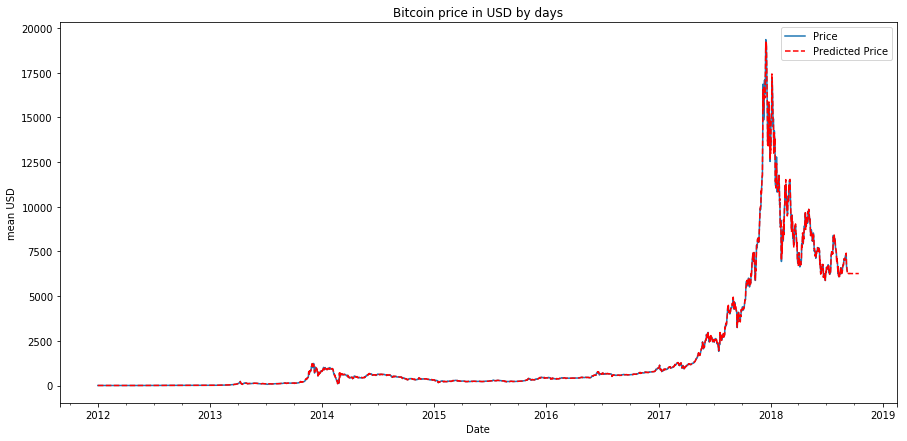

In [62]:
plt.figure(figsize=(15,7))
df['Price'].plot()
pred_price['Pred.Price'].plot(color='r', ls='--', label='Predicted Price') # 'r+'
plt.legend(loc='best')
plt.title('Bitcoin price in USD by days')
plt.ylabel('mean USD')
plt.show()

In [63]:
mse = mean_squared_error(df['Price'], pred_price['Pred.Price'].iloc[:-39])
mse

3611.951303271696

In [66]:
ret_log_dfd = log_dfd.diff().iloc[1:]
ret_log_dfd.columns = ['Ret.Log.Price']
print(ret_log_dfd.head(2))
pred_ret_log = pred_log.diff().iloc[1:]
pred_ret_log.columns = ['Pred.Ret.Log.Price']
print(pred_ret_log.head(2))

            Ret.Log.Price
Date                     
2012-01-02      -0.009533
2012-01-03      -0.067352
            Pred.Ret.Log.Price
Date                          
2012-01-02           -0.009766
2012-01-03           -0.066964


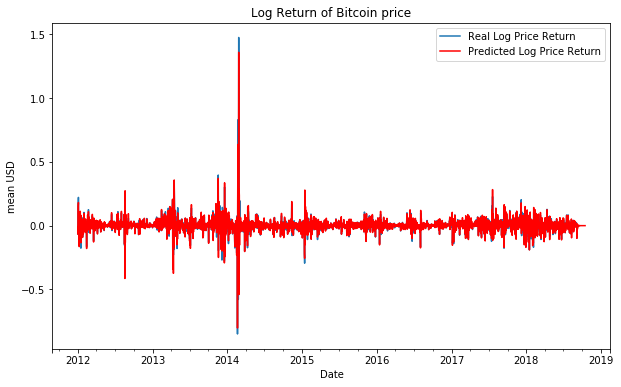

In [67]:
plt.figure(figsize=(10,6))
ret_log_dfd['Ret.Log.Price'].plot(label='Real Log Price Return')
pred_ret_log['Pred.Ret.Log.Price'].plot(color='r', label='Predicted Log Price Return') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [69]:
mse = mean_squared_error(pred_ret_log['Pred.Ret.Log.Price'].iloc[:-39], ret_log_dfd['Ret.Log.Price'])
mse

0.0006943951740406388

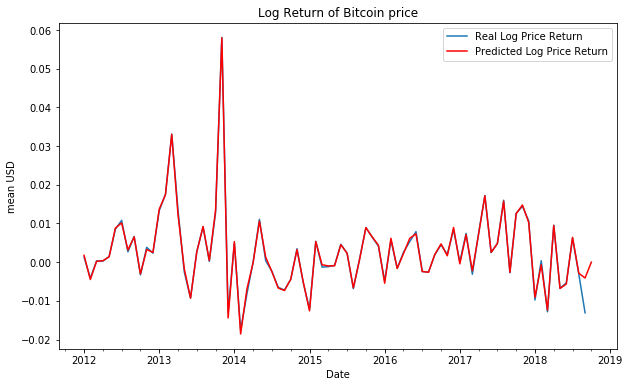

In [70]:
m_ret_log_dfd = ret_log_dfd.resample('M').mean()
m_pred_ret_log = pred_ret_log.resample('M').mean()

plt.figure(figsize=(10,6))
m_ret_log_dfd['Ret.Log.Price'].plot(label='Real Log Price Return')
m_pred_ret_log['Pred.Ret.Log.Price'].plot(color='r', label='Predicted Log Price Return') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [ ]:
sign_check = pd.merge(ret_log_dfm, pred_ret_log, how='left', left_index=True, right_index=True)
print(sign_check.head(2))
print(sign_check.tail(2))
sign_check.shape

In [ ]:
sign_check['check'] = sign_check['Ret.Log.Price'] * sign_check['Pred.Ret.Log.Price']
sign_check.head(2)

In [ ]:
sign_check['check'] = sign_check['check'].apply(lambda x: 1 if x > 0 else 0)
sign_check.head(2)

In [ ]:
np.sum(sign_check.check)/sign_check.shape[0], sign_check.shape[0]

In [ ]:
print('real + and pred +:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real + and pred -:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])
print('real - and pred +:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real - and pred -:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])